In [39]:
import os
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
def cut_remap_netcdf(input_file, reference_file, output_file, lonlatbox):
    """
    Cut a NetCDF file to a specified lon-lat bounding box and save it as a new file.

    Parameters:
        input_file (str): Path to the input NetCDF file.
        lonlatbox (list): Bounding box in the format [lon_min, lon_max, lat_min, lat_max].

    Returns:
        None
    """
    # Unpack the lon-lat bounding box
    lon_min, lon_max, lat_min, lat_max = lonlatbox

    # Open the input NetCDF file
    ds = xr.open_dataset(input_file)
    ds_mask = xr.open_dataset(reference_file)

    # Extract lonlatbox values
    lon_min, lon_max, lat_min, lat_max = lonlatbox

    # Select lat/lon range
    ds_cut = ds.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

    # Interpolate the input data onto the grid of the reference data
    ds_remapped = ds_cut.interp_like(ds_mask)

    # Save the remapped data to a new NetCDF file
    ds_remapped.to_netcdf(output_file)
    print('Processing complete: ',output_file)
    
    return ds_remapped


In [21]:
def get_files(directory, where, format):
    """
    Get a list of all GRIB2 files in the specified directory.

    Parameters:
    - directory: Path to the directory containing the GRIB2 files.
    - format: either '.grb2' or '.nc'
    Returns:
    - List of file paths to the GRIB2 files.
    """
    files = []
    for file_name in os.listdir(directory):
        if where == 'ends':
            if file_name.endswith(format):
                file_path = os.path.join(directory, file_name)
                files.append(file_path)
        elif where == 'starts':
            if file_name.startswith(format):
                file_path = os.path.join(directory, file_name)
                files.append(file_path)
    return files

In [96]:
# Function that will open a netcdf file and access the variables 
def open_netcdf_access_variables(nc_file_path):
    try:
        # Open the NetCDF file using xarray
        ds = xr.open_dataset(nc_file_path)

        # Access all variables and assign variable names
        variables = {}
        for var_name in ds.variables:
            variables[var_name] = ds[var_name]

        return variables

    except Exception as e:
        print("Error:", e)
        return None

In [ ]:
# Function to calculate the area of a grid cell
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their longitudes and latitudes
    in degrees.
    """
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [32]:
def calculate_variable(calc_type, input_variable, mask_variable, ds_regridded, ds_mask):
    """
    Parameters:
    - calc_type (str): how to calculate the data, either 'sum' or 'mean'
    - input_variable (str): the variable to be calculated
    - mask_variable (str): the land/lake/basin variable from the mask file
    - input_file (str): path to the input netcdf file
    - mask_file (str): path to the mask netcdf file
    Returns:
    - Calculated value of the sum/mean of the given variable over the land/lake/basin
    """
    try:
        # Extract precipitation data and mask values
        input_data = ds_regridded[input_variable]
        mask_values = ds_mask[mask_variable]
        masked_data = input_data.where(mask_values == 1)

        # Calculate data sum or mean over the masked area
        if calc_type == 'sum':
            calculated_data = masked_data.sum(dim=['latitude', 'longitude'])
        elif calc_type == 'mean':
            calculated_data = masked_data.mean(dim=['latitude', 'longitude'])
        else:
            print("Calculation Type needs to be 'sum' or 'mean'.")

        return calculated_data

    except Exception as e:
        print("Error:", e)
        return None

In [81]:
# Defined constants based on today's date and not required as input from the user
today = datetime.today()
yesterday = (today - timedelta(days=1)).strftime('%Y%m%d')

eventtime = today.replace(day=1).strftime('%Y-%m-%d')
date = today.strftime('%Y%m%d')

# Predefined variables
var1=['tmp2m','lhtfl','apcp']
varnc1=['TMP_2maboveground','LHTFL_surface','APCP_surface']

In [8]:
# Constants
# Defines box encompassing the entire Great Lakes Basin
#lonlatbox = [-110,-65,30,70]
lonlatbox = [250,295,30,70]

# Which daily CFS run cycles would we like to download, process, and add to our csv basin files
utc = ['00','06','12','18']

output_files = ["CFS_APCP_Basin_Sums.csv", "CFS_APCP_Basin_Avgs.csv",
                "CFS_EVAP_Basin_Sums.csv", "CFS_EVAP_Basin_Avgs.csv",
                "CFS_LHFX_Basin_Sums.csv", "CFS_LHFX_Basin_Avgs.csv",
                "CFS_TMP_Basin_Avgs.csv", "GL_Basin_Sizes.csv"]

In [23]:
# Inputs from the user
download_dir = f'C:/Users/fitzpatrick/Desktop/Data/{yesterday}/downloaded/'
output_dir = f'C:/Users/fitzpatrick/Desktop/Data/{yesterday}/processed/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
else:
    print(f"Directory already exists.")

In [ ]:
# Loop set up to cut and remap all the netcdf files and place them in a new directory.
download_dir = 'C:/Users/fitzpatrick/Desktop/Data/20240602/downloaded/'
output_dir = 'C:/Users/fitzpatrick/Desktop/Data/20240602/processed/'
mask = 'C:/Users/fitzpatrick/Desktop/Data/Input/GL_mask.nc'
lonlatbox = [250,295,30,70]

file_list = get_files(download_dir, 'ends', '.nc')

# Use the function defined above to cut the netcdf files to the GL domain and upscale to 0.25 degrees
for file in file_list:
    # Split the filename
    filename = os.path.basename(file) #pulls the filename from the entire path
    name, ext = os.path.splitext(filename) #splits the filename at the '.nc' so we can change the filename
    # Create new file names for the new files
    new_filename = name + '.GL025' + ext
    new_netcdf = cut_remap_netcdf(file, mask, output_dir+new_filename, lonlatbox)

In [57]:
calc_type = 'mean'
mask_variable = ['eri_lake','eri_land','eri_basin',
                 'hur_lake','hur_land','hur_basin',
                 'ont_lake','ont_land','ont_basin',
                 'mic_lake','mic_land','mic_basin',
                 'sup_lake','sup_land','sup_basin']
flx_variables = ['TMP_2maboveground','LHTFL_surface']
flx_shortname = ['TMP','LH']
pgb_variables = ['APCP_surface']
pgb_shortname = ['APCP']

df_apcp_forecasts = pd.DataFrame(columns=['cfs_run', 'utc', 'forecast_month'] + mask_variable)
df_tmp_forecasts = pd.DataFrame(columns=['cfs_run', 'utc', 'forecast_month'] + mask_variable)
df_lhtfl_forecasts = pd.DataFrame(columns=['cfs_run', 'utc', 'forecast_month'] + mask_variable)

In [49]:
## ACPC_surface is in kg/m2
file_list = get_files(output_dir, 'starts', 'pgb')

counter = 0 #this is the row in the dataframe df_apcp_forecasts
for file in file_list:
    #open the files outside of the function
    ds_regridded = xr.open_dataset(file)
    ds_mask = xr.open_dataset(mask)
    file_parts = file.split('.')
    cfs_run = file_parts[2]
    forecast = datetime.strptime(file_parts[3], '%Y%m')
    forecast_month = forecast.strftime('%B')
    utc = file_parts[-3][:-1]
    df_apcp_forecasts.loc[counter,'cfs_run'] = cfs_run
    df_apcp_forecasts.loc[counter, 'utc'] = utc
    df_apcp_forecasts.loc[counter, 'forecast_month'] = forecast_month

    for type in mask_variable:
        df_apcp_forecasts.loc[counter, type] = calculate_variable('sum', 'APCP_surface', type, ds_regridded, ds_mask)

    counter += 1

    ds_regridded.close()
    ds_mask.close()


In [50]:
print(df_apcp_forecasts)

# Convert kg/m2 to cms

lat = nc_file.variables['lat'][:]
lon = nc_file.variables['lon'][:]
lat_spacing = np.abs(lat[1] - lat[0])
lon_spacing = np.abs(lon[1] - lon[0])
area_of_grid_cell = lat_spacing * lon_spacing
    
# Calculate total precipitation
total_precipitation = np.sum(precipitation_data) * area_of_grid_cell
    
# Convert total precipitation from kg/m^2 to m^3/s (assuming 1 kg/m^2 = 1 mm)
total_precipitation_m3_per_s = total_precipitation / (1000 * 3600 * 24) # 1 day = 24 hours

        cfs_run utc forecast_month   eri_lake    eri_land   eri_basin  \
0    2024060200  00           June  32.982563  211.991439  213.834126   
1    2024060200  06           June  35.906312  208.595500  224.253437   
2    2024060200  12           June  26.478313  136.811187  148.838625   
3    2024060200  18           June  24.825500  157.743625  158.060563   
4    2024060200  00           July  16.092562  136.340998  125.568186   
..          ...  ..            ...        ...         ...         ...   
155  2024060218  18       February  10.860563   52.037625   56.657813   
156  2024060218  00          March  13.112812   66.668000   71.912625   
157  2024060218  06          March  14.163500   64.652876   73.315688   
158  2024060218  12          March   9.114875   44.573687   48.262812   
159  2024060218  18          March  10.200688   62.100438   62.575313   

      hur_lake    hur_land   hur_basin   ont_lake    ont_land   ont_basin  \
0    34.251125  184.290188  186.826751  23.972

In [60]:
file_list = get_files(output_dir, 'starts', 'flx')

counter = 0 #this is the row in the dataframe df_apcp_forecasts
for file in file_list:
    #open the files outside of the function
    ds_regridded = xr.open_dataset(file)
    ds_mask = xr.open_dataset(mask)
    file_parts = file.split('.')
    cfs_run = file_parts[2]
    forecast = datetime.strptime(file_parts[3], '%Y%m')
    forecast_month = forecast.strftime('%B')
    utc = file_parts[-3][:-1]
    df_tmp_forecasts.loc[counter,'cfs_run'] = cfs_run
    df_lhtfl_forecasts.loc[counter,'cfs_run'] = cfs_run
    df_tmp_forecasts.loc[counter, 'utc'] = utc
    df_lhtfl_forecasts.loc[counter,'utc'] = utc
    df_tmp_forecasts.loc[counter, 'forecast_month'] = forecast_month
    df_lhtfl_forecasts.loc[counter, 'forecast_month'] = forecast_month

    for type in mask_variable:
        df_tmp_forecasts.loc[counter, type] = calculate_variable('mean', 'TMP_2maboveground', type, ds_regridded, ds_mask)
        print(df_tmp_forecasts.loc[counter, type])
        df_lhtfl_forecasts.loc[counter, type] = calculate_variable('mean', 'LHTFL_surface', type, ds_regridded, ds_mask)
    counter += 1

    ds_regridded.close()
    ds_mask.close()

In [62]:
print(df_lhtfl_forecasts)

        cfs_run utc forecast_month  \
0    2024060200  00           June   
1    2024060200  06           June   
2    2024060200  12           June   
3    2024060200  18           June   
4    2024060200  00           July   
..          ...  ..            ...   
155  2024060218  18       February   
156  2024060218  00          March   
157  2024060218  06          March   
158  2024060218  12          March   
159  2024060218  18          March   

                                              eri_lake  \
0    [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
1    [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
2    [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
3    [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
4    [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
..                                                 ...   
155  [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
156  [<xarray.DataArray 'LHTFL_surface' ()> Size: 8...   
157  [<xarray.DataArr

In [ ]:

# Create dataframes to organize data that will later be saved as CSV files
column_names = ['Forecast','UTC','January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_eri_lake = pd.DataFrame(columns=column_names)
df_eri_land = pd.DataFrame(columns=column_names)
df_eri_basin = pd.DataFrame(columns=column_names)

file_list = get_files(output_dir, 'starts', 'pgb')

for file in file_list:
    #open the files outside of the function
    ds_regridded = xr.open_dataset(file)
    ds_mask = xr.open_dataset(mask)
    file_parts = file.split('.')
    cfsrun = file_parts[2]
    forecast = datetime.strptime(file_parts[3], '%Y%m')
    forecast_month = forecast.strftime('%B')
    time = file_parts[-3][:-1]
   
    
    #for type in mask_variable:
    #    eri_lake_apcp_mean = calculate_variable('mean', 'APCP_surface', type, ds_regridded, ds_mask)
    
    eri_lake_apcp_mean = calculate_variable('mean', 'APCP_surface', 'eri_lake', ds_regridded, ds_mask)
    print(cfsrun, forecast_month, time, eri_lake_apcp_mean)
    ds_regridded.close()
    ds_mask.close()

eri_lake_tmp_mean = calculate_variable('mean', 'TMP_2maboveground', 'eri_lake', new_netcdf, mask)
#eri_lake_lhtfl_mean = calculate_variable('mean', 'LHTFL_surface', 'eri_lake', new_netcdf, mask)

#print(eri_lake_tmp_mean)

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 181, latitude: 161)
Coordinates:
  * longitude  (longitude) float64 1kB 250.0 250.2 250.5 ... 294.5 294.8 295.0
  * latitude   (latitude) float64 1kB 30.0 30.25 30.5 30.75 ... 69.5 69.75 70.0
Data variables: (12/15)
    eri_basin  (latitude, longitude) float32 117kB ...
    eri_land   (latitude, longitude) float32 117kB ...
    hur_basin  (latitude, longitude) float32 117kB ...
    hur_land   (latitude, longitude) float32 117kB ...
    mic_basin  (latitude, longitude) float32 117kB ...
    mic_land   (latitude, longitude) float32 117kB ...
    ...         ...
    sup_land   (latitude, longitude) float32 117kB ...
    eri_lake   (latitude, longitude) float32 117kB ...
    hur_lake   (latitude, longitude) float32 117kB ...
    mic_lake   (latitude, longitude) float32 117kB ...
    ont_lake   (latitude, longitude) float32 117kB ...
    sup_lake   (latitude, longitude) float32 117kB ...
Attributes:
    CDI:              Climate Data Int

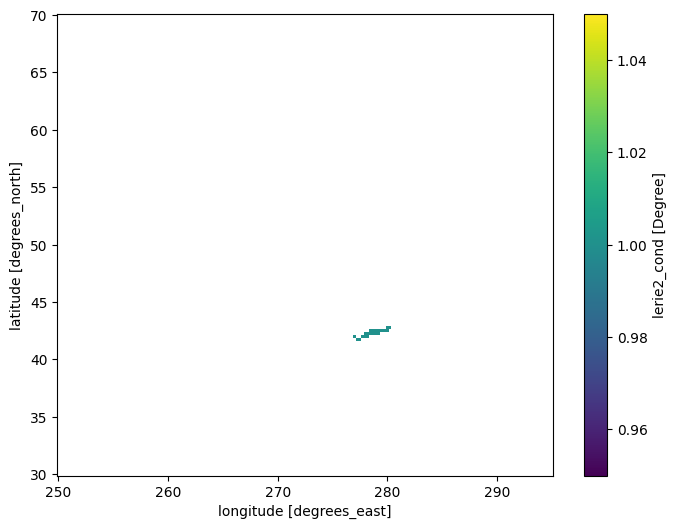

In [59]:
import xarray as xr
import matplotlib.pyplot as plt

mask_path = 'C:/Users/fitzpatrick/Desktop/Data/Input/GL_mask.nc'
ds = xr.open_dataset(mask_path)
print(ds)
variable = ds['eri_lake']
# Plot the variable
plt.figure(figsize=(8, 6))
variable.plot()
plt.show()




In [ ]:
for files in output_files:
    create_csv_file(files)

